#### 1. Importing Required Libraries

In [1]:
# !pip install deep_translator googletrans spacy huggingface_hub catboost

In [2]:
# !python -m spacy download ru_core_news_sm

In [3]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD, PCA, LatentDirichletAllocation
from scipy.sparse import hstack
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, f1_score
from imblearn.over_sampling import SMOTE
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, Dropout, Conv1D, MaxPooling1D, GlobalAveragePooling1D
from googletrans import Translator
import xgboost as xgb
from xgboost import XGBClassifier
import nltk
import gensim
from transformers import BertTokenizer, TFBertForSequenceClassification
from nltk.corpus import stopwords
import spacy
from collections import Counter
import torch
from transformers import BertTokenizer, BertForTokenClassification, pipeline
from catboost import CatBoostClassifier

In [4]:
# Download Russian stopwords
nltk.download("stopwords")
from nltk.corpus import stopwords

russian_stopwords = stopwords.words("russian")

[nltk_data] Downloading package stopwords to C:\Users\Nirmal Dev
[nltk_data]     Aravind\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#### 2. Loading the Data

In [5]:
# Load dataset
file_path = "thesis.xlsx"
df = pd.read_excel(file_path)

In [6]:
df.head()

,patients_id,sex,dob,create_date_time,rhythm,p_wave_1,p_wave_2,p_wave_3,t_wave_1,t_wave_2,...,systole_duration_QRST,heart_rate,blood_group,rhesus_factor,description,bundle_branch_block,episode,glucose,cholesterol,dead
0,14965,Женский,24.09.1943,26.09.2008 10:15:43,синусовый,+,+,+,+,+,...,0.400 сек,49,B (III),положительный,"Ритм синусовый, правильный. Синусовая брадикар...",горизонтальное,NaN,5.20,131.0,Нет
1,22431,Мужской,27.03.1955,10.10.2006 15:21:42,синусовый,+,+,+,+,+,...,0.410 сек,70,A (II),положительный,Ритм синусовый. Политопные экстрасистолы из а-...,нормальное,NaN,6.31,181.0,Нет
2,22431,Мужской,27.03.1955,10.10.2006 15:21:42,синусовый,+,+,+,+,+,...,0.410 сек,70,A (II),положительный,Ритм синусовый. Политопные экстрасистолы из а-...,нормальное,NaN,6.71,221.0,Нет
3,4744,Мужской,27.04.1965,18.01.2006 09:52:26,синусовый,NaN,NaN,NaN,NaN,NaN,...,NaN,0,AB (IV),положительный,Замедление внутри жел. проводимости.В остально...,отклонение влево,NaN,5.64,298.0,Нет
4,4744,Мужской,27.04.1965,18.01.2006 09:52:26,синусовый,NaN,NaN,NaN,NaN,NaN,...,NaN,0,AB (IV),положительный,Замедление внутри жел. проводимости.В остально...,отклонение влево,NaN,6.00,259.0,Нет


In [7]:
# Display basic information about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146552 entries, 0 to 146551
Data columns (total 26 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   patients_id            146552 non-null  int64  
 1   sex                    146552 non-null  object 
 2   dob                    146548 non-null  object 
 3   create_date_time       146494 non-null  object 
 4   rhythm                 109223 non-null  object 
 5   p_wave_1               86449 non-null   object 
 6   p_wave_2               86449 non-null   object 
 7   p_wave_3               86448 non-null   object 
 8   t_wave_1               86502 non-null   object 
 9   t_wave_2               86497 non-null   object 
 10  t_wave_3               86490 non-null   object 
 11  t_wave_4               86036 non-null   object 
 12  qrs                    86388 non-null   object 
 13  qrs_interval           86223 non-null   object 
 14  pq_interval            83927 non-nul

#### 3. Data Cleaning and Preprocessing

In [8]:
# Calculate Age (based on dob and create_date_time)
# Convert dates correctly
df["dob"] = pd.to_datetime(df["dob"], errors="coerce", dayfirst=True)
df["create_date_time"] = pd.to_datetime(df["create_date_time"], errors="coerce", dayfirst=True)
# Calculate Age
df["age"] = (pd.Timestamp.today() - df["dob"]).dt.days // 365
# Fill missing values correctly
df["age"] = df["age"].fillna(df["age"].median())
# Drop DateofBirth and DateofRegistration
df = df.drop(columns=["dob", "create_date_time"])

In [9]:
# Convert 'dead' column to binary (0 for alive, 1 for dead)
df['dead'] = df['dead'].map({'Нет': 0, 'Да': 1})

# Verify the changes
print(df['dead'].value_counts())

dead
0    145889
1       663
Name: count, dtype: int64


In [10]:
# Assuming df is your DataFrame containing missing data
missing_values = df.isnull().sum().sort_values(ascending=False)
missing_percentage = (missing_values / len(df)) * 100

# Create a DataFrame
missing_data = pd.DataFrame({'Missing Values': missing_values, 'Percentage': missing_percentage})
missing_data = missing_data[missing_data['Missing Values'] > 0]

# Display the missing data summary
print(missing_data)

                       Missing Values  Percentage
episode                        111456   76.052186
pq_interval                     62625   42.732273
systole_duration_QRST           61722   42.116109
t_wave_4                        60516   41.293193
qrs_interval                    60329   41.165593
segment                         60243   41.106911
qrs                             60164   41.053005
p_wave_3                        60104   41.012064
p_wave_1                        60103   41.011382
p_wave_2                        60103   41.011382
t_wave_3                        60062   40.983405
t_wave_2                        60055   40.978629
t_wave_1                        60050   40.975217
rhesus_factor                   50678   34.580217
blood_group                     50516   34.469676
bundle_branch_block             46563   31.772340
rhythm                          37329   25.471505
description                      1524    1.039904
glucose                           241    0.164447


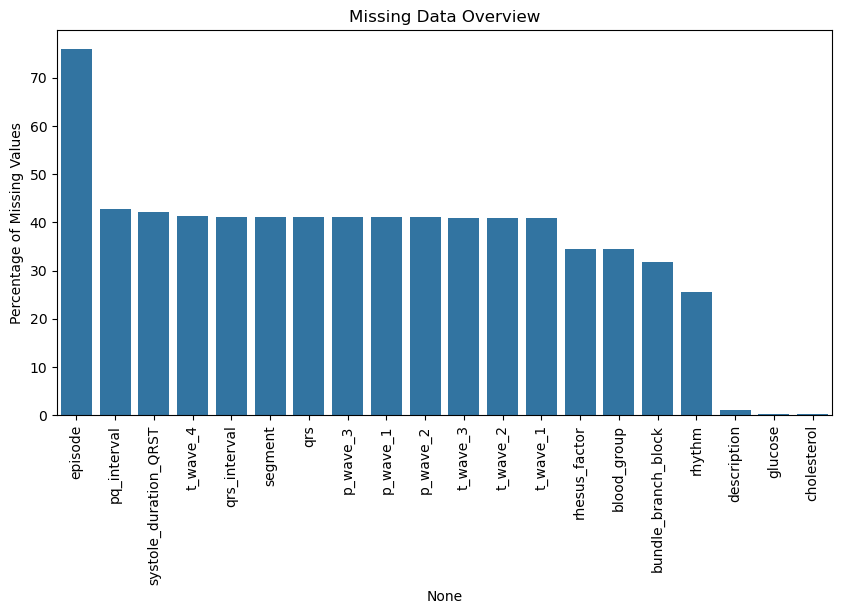

In [11]:
plt.figure(figsize=(10, 5))
sns.barplot(x=missing_data.index, y=missing_data['Percentage'])
plt.xticks(rotation=90)
plt.ylabel('Percentage of Missing Values')
plt.title('Missing Data Overview')
plt.show()

### Exploring Numerical Features

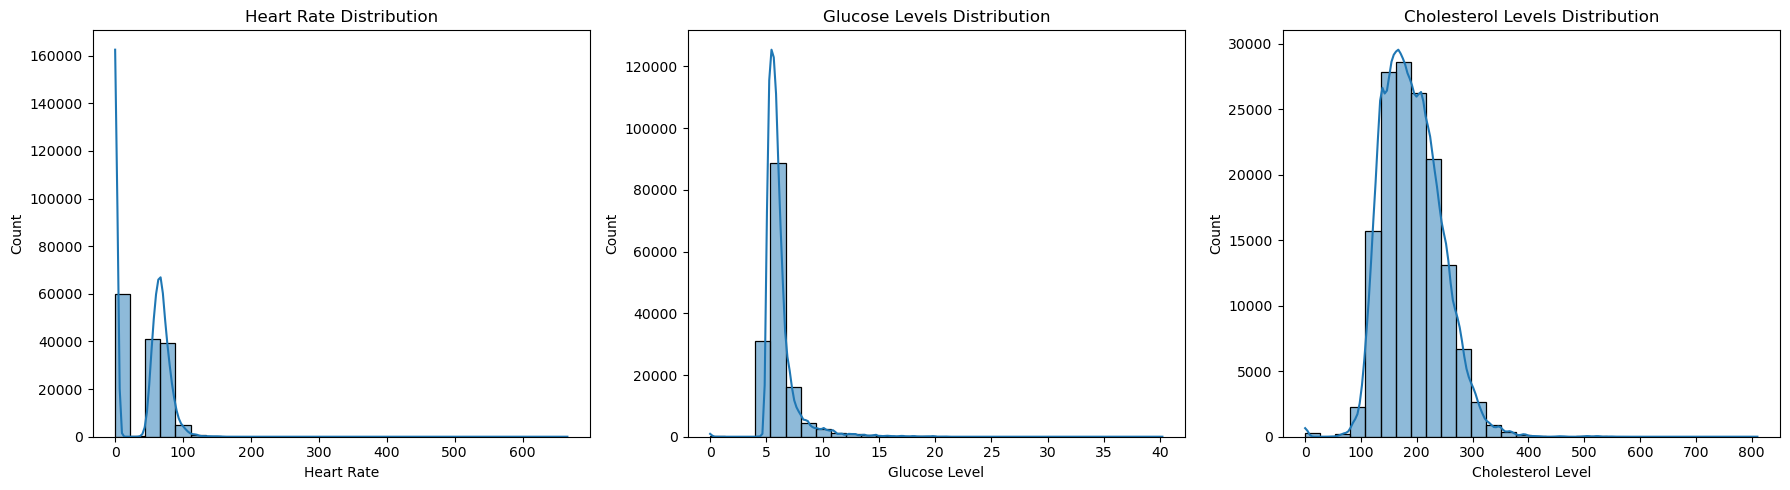

In [12]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Heart Rate Distribution
sns.histplot(df["heart_rate"], bins=30, kde=True, ax=axes[0])
axes[0].set_title("Heart Rate Distribution")
axes[0].set_xlabel("Heart Rate")

# Glucose Distribution
sns.histplot(df["glucose"], bins=30, kde=True, ax=axes[1])
axes[1].set_title("Glucose Levels Distribution")
axes[1].set_xlabel("Glucose Level")

# Cholesterol Distribution
sns.histplot(df["cholesterol"], bins=30, kde=True, ax=axes[2])
axes[2].set_title("Cholesterol Levels Distribution")
axes[2].set_xlabel("Cholesterol Level")

plt.tight_layout()
plt.show()

#### Insights from Numerical Feature Distributions
Heart Rate Distribution: A large spike at zero, suggesting missing or faulty recordings.
Some extreme values (>200 bpm), which may need outlier detection.

Glucose Levels Distribution: Most values range between 5-7 mmol/L, with a few extreme outliers.
Skewed distribution, indicating a need for log transformation or normalization.

Cholesterol Levels Distribution: Peaks around 200 mg/dL, which aligns with normal cholesterol levels.
Some extremely high values (>500 mg/dL) may be measurement errors or rare cases.

### Exploring the Relationship Between Features and Heart Disease

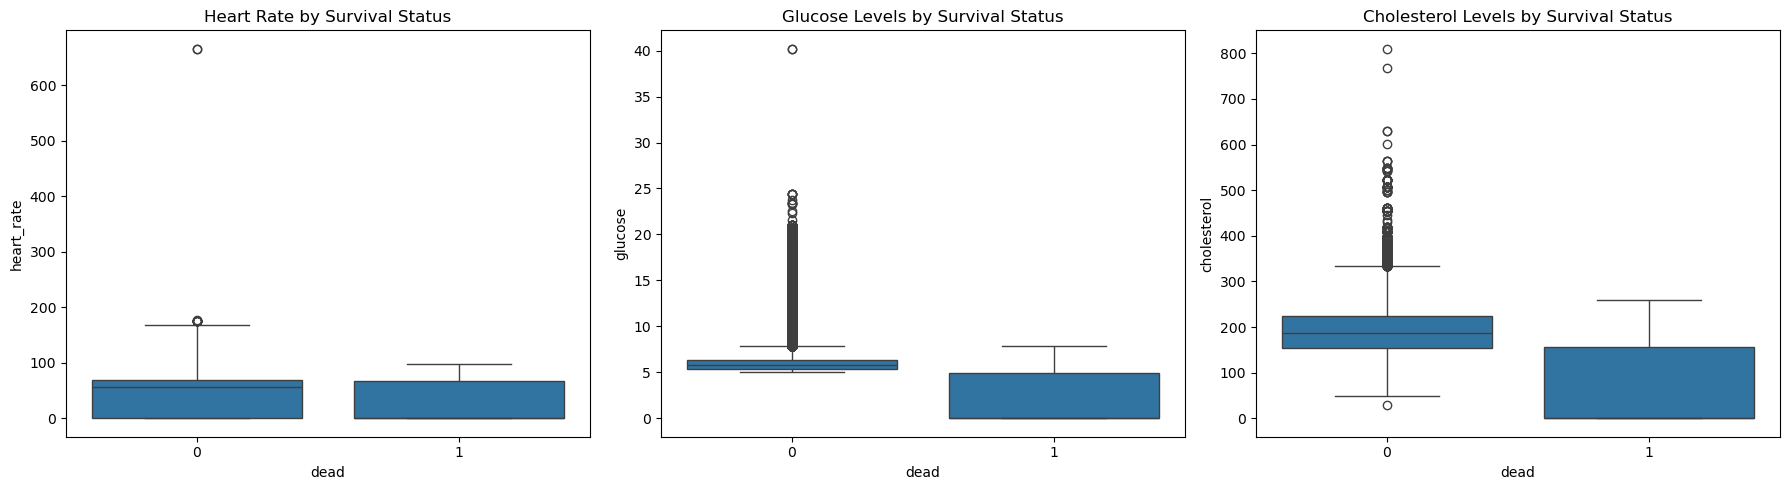

In [13]:
# Box plots to compare distributions of numerical features between alive and deceased patients
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Heart Rate vs. Survival Status
sns.boxplot(data=df, x="dead", y="heart_rate", ax=axes[0])
axes[0].set_title("Heart Rate by Survival Status")

# Glucose vs. Survival Status
sns.boxplot(data=df, x="dead", y="glucose", ax=axes[1])
axes[1].set_title("Glucose Levels by Survival Status")

# Cholesterol vs. Survival Status
sns.boxplot(data=df, x="dead", y="cholesterol", ax=axes[2])
axes[2].set_title("Cholesterol Levels by Survival Status")

plt.tight_layout()
plt.show()

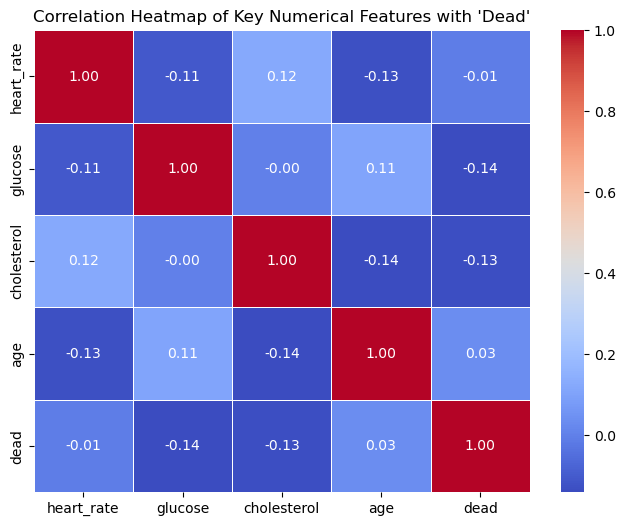

In [14]:
numerical_columns = ['heart_rate', 'glucose', 'cholesterol','age', 'dead']

# Correlation heatmap (numerical features)
corr_matrix = df[numerical_columns].corr()

# Plot correlation heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap of Key Numerical Features with 'Dead'")
plt.show()

#### Insights from Numerical Feature Comparison by Survival Status
Heart Rate vs. Survival:

The median heart rate is slightly lower in deceased patients.
Some extreme outliers (>600 bpm) might be data errors. 

Glucose vs. Survival:

No strong visible difference between groups.
Some very high glucose values (>25 mmol/L), which may indicate severe diabetes cases.

Cholesterol vs. Survival:

Deceased patients tend to have a wider range of cholesterol levels.
Extremely high cholesterol values (>500 mg/dL) suggest potential heart disease risks.

### Exploring Categorical Features

In [15]:
print(df.blood_group.value_counts())

blood_group
A (II)                   30245
0 (I)                    27437
B (III)                  24724
AB (IV)                   6531
A (II)A (II)              2082
0 (I)0 (I)                1942
B (III)B (III)            1008
AB (IV)AB (IV)             855
0 (I)0 (I)0 (I)            512
A (II)A (II)A (II)         447
B (III)B (III)B (III)       62
вторая                      60
A (II                       46
0(I)                        24
AB (IV)AB (IV)AB (IV)       22
0 (I) 0 (I)                 16
A(II)                        9
B (III                       6
не определена                3
AB (IV)B (III)AB (IV)        2
A (II) A (II)                2
0 (I                         1
Name: count, dtype: int64


In [16]:
# Function to simplify blood group categories to A, B, AB, and O
def simplify_blood_group(value):
    value = str(value).strip()

    # If the value is "вторая", map it to "A"
    if value == "вторая":
        return "A"

    # Standardize main blood groups
    if "AB" in value:
        return "AB"
    elif "A" in value:
        return "A"
    elif "B" in value:
        return "B"
    elif "0" in value or "O" in value:
        return "O"
    return "Unknown"

# Apply the function to simplify blood group data
df["blood_group"] = df["blood_group"].apply(simplify_blood_group)

# Display the updated blood group distribution
print(df["blood_group"].value_counts())

blood_group
Unknown    50519
A          32891
O          29932
B          25800
AB          7410
Name: count, dtype: int64


#### Heart Rate

In [17]:
((df['heart_rate'] == 0) & (df['dead'] == 0)).sum()

59786

#### Heart_rate is 0 for 59786 alive patients which is quite impossible

In [18]:
# Function to extract heart rate from text fields
def extract_heart_rate(text):
    if isinstance(text, str):
        # Improved regex pattern to capture heart rate after 'ЧСС' with different formats
        match = re.search(r'чсс[:=\s-]*(\d{2,3})', text.lower())  
        if match:
            heart_rate = int(match.group(1))
            # Validate extracted heart rate (reasonable range 30-250 bpm)
            if 30 <= heart_rate <= 250:
                return heart_rate
    return None  # Return None if no valid heart rate is found

# Apply extraction to both 'description' and 'episode' columns
df['extracted_heart_rate'] = df['description'].apply(extract_heart_rate)
df['extracted_heart_rate'] = df['extracted_heart_rate'].combine_first(df['episode'].apply(extract_heart_rate))

# Replace 0 values in 'heart_rate' with extracted values where available
df['heart_rate'] = np.where((df['heart_rate'] == 0) & (df['extracted_heart_rate'].notna()), 
                            df['extracted_heart_rate'], df['heart_rate'])

# Drop temporary column
df.drop(columns=['extracted_heart_rate'], inplace=True)

In [19]:
((df['heart_rate'] == 0) & (df['dead'] == 0)).sum()

57100

### ECG

In [20]:
# Function to standardize wave text safely and clean non-standard values
def standardize_wave_text(text):
    if isinstance(text, str):
        text = text.strip().lower()
        
        # Handling known descriptive values
        if "сглажен" in text or "сглажены" in text:
            return "smooth"
        if "инверсия" in text or "инвертирован" in text:
            return "inversion"
        if "изоэл." in text or "изоэлектрический" in text:
            return "isoel"
        if "к+" in text or "p-mitrale" in text:
            return "p_mitrale"
        if "нет" in text:
            return "no_wave"
    
    return text if isinstance(text, str) else ''

# Define wave symbol to numeric mapping
wave_mapping = {
    '--': -2, '---': -3, '-': -1, '+-': 0, '+': 1, '++': 2, '+++': 3,
    'smooth': 0, 'inversion': -1, 'isoel': 0, 'p_mitrale': 1, 'no_wave': np.nan
}

# Improved regex to match +, -, ++, --, +++, --- symbols
pattern = re.compile(r'(--|\+\+|---|\+\+\+|[-+]{1,2})')

# List of wave-related columns
wave_columns = [col for col in df.columns if "wave" in col]

for col in wave_columns:
    # Handle missing values by replacing NaN with an empty string
    df[col] = df[col].fillna('')
    
    # Step 1: Standardize wave text first
    df[col] = df[col].apply(standardize_wave_text)

    # Step 2: Extract and clean symbols using regex
    df[col] = df[col].apply(lambda x: pattern.findall(x))

    # Step 3: Convert extracted symbols to numeric values
    df[col] = df[col].apply(lambda x: [wave_mapping.get(item, np.nan) for item in x] if x else np.nan)

    # Step 4: If multiple values are found, take the **median**
    df[col] = df[col].apply(lambda x: np.nanmedian(x) if isinstance(x, list) and x else np.nan)

    # Step 5: Fill remaining NaN values with median of the column
    df[col] = df[col].fillna(df[col].median())

C:\temp\ipykernel_95056\3049258561.py:46: RuntimeWarning: All-NaN slice encountered
  df[col] = df[col].apply(lambda x: np.nanmedian(x) if isinstance(x, list) and x else np.nan)


#### Time-Related ECG Columns

In [21]:
# List of columns containing values with "сек" (seconds)
time_columns = ['qrs_interval', 'pq_interval', 'systole_duration_QRST']

# Function to clean time-related columns by extracting numeric values and removing extra text
def extract_numeric_value(text):
    # Check if the value is a string
    if isinstance(text, str):
        # Use regex to extract the numeric value (allows decimals too)
        match = re.search(r'(\d+\.?\d*)', text)
        if match:
            return float(match.group(1))  # Convert the matched number to a float
    return np.nan  # Return NaN if no numeric value is found

# Apply the cleaning function to each of the columns
for col in time_columns:
    df[col] = df[col].apply(extract_numeric_value)

# Verify the changes
print(df[time_columns].head())

   qrs_interval  pq_interval  systole_duration_QRST
0          0.08         0.14                   0.40
1          0.09         0.19                   0.41
2          0.09         0.19                   0.41
3           NaN          NaN                    NaN
4           NaN          NaN                    NaN


#### Rhythm

In [22]:
# Load the spaCy model for Russian
nlp = spacy.load("ru_core_news_sm")

In [23]:
# Function to extract medical terms from rhythm descriptions using spaCy NLP
def extract_medical_terms(text):
    if isinstance(text, str):
        doc = nlp(text.lower())  # Process text using spaCy NLP model

        # Extract nouns and adjectives related to medical rhythm descriptions
        extracted_terms = [token.text for token in doc if token.pos_ in ["NOUN", "ADJ"]]

        # Keep the most relevant terms (up to 3 words for simplicity)
        return " ".join(extracted_terms[:3])
    return None

# Apply the function to extract medical terms from the 'rhythm' column
df["rhythm_extracted"] = df["rhythm"].apply(extract_medical_terms)

df[['rhythm', 'rhythm_extracted']].head(20)

,rhythm,rhythm_extracted
0,синусовый,синусовый
1,синусовый,синусовый
2,синусовый,синусовый
3,синусовый,синусовый
4,синусовый,синусовый
5,синусовый,синусовый
6,синусовый,синусовый
7,синусовый,синусовый
8,синусовый,синусовый
9,синусовый,синусовый


In [24]:
# Drop the 'rhythm'columns
df.drop(columns=['rhythm','patients_id'], inplace=True)

#### QRS, bundle_branch_block, rhesus

In [25]:
df[['qrs','bundle_branch_block','rhesus_factor']].value_counts()

qrs              bundle_branch_block      rhesus_factor 
не деформирован  нормальное               положительный     16649
                 горизонтальное           положительный     10605
                 резкое отклонение влево  положительный      7491
                 отклонение влево         положительный      4481
                 вертикальное             положительный      3688
                                                            ...  
                 ось S I  Q III           положительный         1
                 ЭОС тип S                отрицательный         1
                 ЭОС типа SI-S II-S III.  положительный         1
                 горизонтальное           положительный         1
уширен           горизонтальное           положительный         1
Name: count, Length: 99, dtype: int64

In [26]:
# Helper function to clean text (convert to lowercase, remove extra spaces, punctuation, and normalize formats)
def clean_text(text):
    if isinstance(text, str):
        text = text.lower().strip()
        text = re.sub(r'\s+', ' ', text)
        text = re.sub(r'[^\w\s-]', '', text)
        return text
    return 'unknown'

# Improved Mapping Dictionaries with expanded coverage
qrs_mapping = {
    'деформирован': 'deformed',
    'не деформирован': 'not_deformed',
    'q': 'q_wave',
    'позиционн': 'position',
    'низкий': 'low_voltage',
    'рср': 'rsr',
    'отсутствует': 'absent_q_wave',
    'расширен': 'widened_qrs',
    'укорочен': 'shortened_qrs',
    'unknown': 'unknown'
}

bundle_branch_block_mapping = {
    'нормальное': 'normal',
    'горизонтальное': 'horizontal',
    'резкое отклонение влево': 'sharp_left_deviation',
    'отклонение влево': 'left_deviation',
    'вертикальное': 'vertical',
    'эос тип s1-s2-s3': 'eos_s1_s2_s3',
    'резкое отклонение вправо': 'sharp_right_deviation',
    'отклонение вправо': 'right_deviation',
    'частичная блокада': 'partial_block',
    'полная блокада': 'complete_block',
    'неопределенный': 'undefined',
    'unknown': 'unknown'
}

rhesus_mapping = {
    'положительный': 'positive',
    'отрицательный': 'negative',
    'неизвестный': 'unknown'
}

# Function to apply mapping
def map_values(value, mapping_dict):
    cleaned_value = clean_text(value)
    return mapping_dict.get(cleaned_value, 'unknown')

# Apply the mapping to relevant columns
df['qrs_cleaned'] = df['qrs'].apply(lambda x: map_values(x, qrs_mapping))
df['bundle_branch_block_cleaned'] = df['bundle_branch_block'].apply(lambda x: map_values(x, bundle_branch_block_mapping))
df['rhesus_factor_cleaned'] = df['rhesus_factor'].apply(lambda x: map_values(x, rhesus_mapping))

# Drop the original columns to avoid confusion
df.drop(columns=['qrs', 'bundle_branch_block', 'rhesus_factor'], inplace=True)

# Verify the changes
print(df[['qrs_cleaned', 'bundle_branch_block_cleaned', 'rhesus_factor_cleaned']].head())

    qrs_cleaned bundle_branch_block_cleaned rhesus_factor_cleaned
0  not_deformed                  horizontal              positive
1  not_deformed                      normal              positive
2  not_deformed                      normal              positive
3       unknown              left_deviation              positive
4       unknown              left_deviation              positive


### Segment

In [27]:
df.segment.value_counts()

segment
изоэлектричен                                                                 86043
депрессия                                                                        44
депрессия до 1 мм                                                                34
косонисходящая депрессия                                                         26
депрессия до 0.5 мм                                                              18
депрессия до 3 мм.                                                               16
элевация                                                                         10
косонисходящая депрессия в V4-6                                                  10
элевация до 0.5 мм                                                                8
элевация до 0.5 см                                                                7
элевация до 1 см                                                                  7
неустойчивая депрессия ST до 0,5 мм в II AVF V6 отвед               

In [28]:
# Function to clean and extract meaningful information from 'segment' column
def process_segment(text):
    if not isinstance(text, str):
        return "unknown", np.nan

    text = text.lower().strip()

    # Define categories
    if "депрессия" in text:
        category = "depression"
    elif "элевация" in text:
        category = "elevation"
    elif "изоэлектричен" in text:
        category = "neutral"
    else:
        category = "other"

    # Extract numeric value of ST depression/elevation (e.g., "до 1 мм", "до 3 мм")
    match = re.search(r'(\d+\.?\d*)\s*мм', text)
    if match:
        st_change_value = float(match.group(1))
    else:
        st_change_value = np.nan

    return category, st_change_value

# Apply function to the 'segment' column
df[['segment_category', 'st_change_value']] = df['segment'].apply(lambda x: process_segment(x)).apply(pd.Series)

In [29]:
# Drop the original columns to avoid confusion
df.drop(columns=['segment'], inplace=True)

#### Let us analyze categorical features

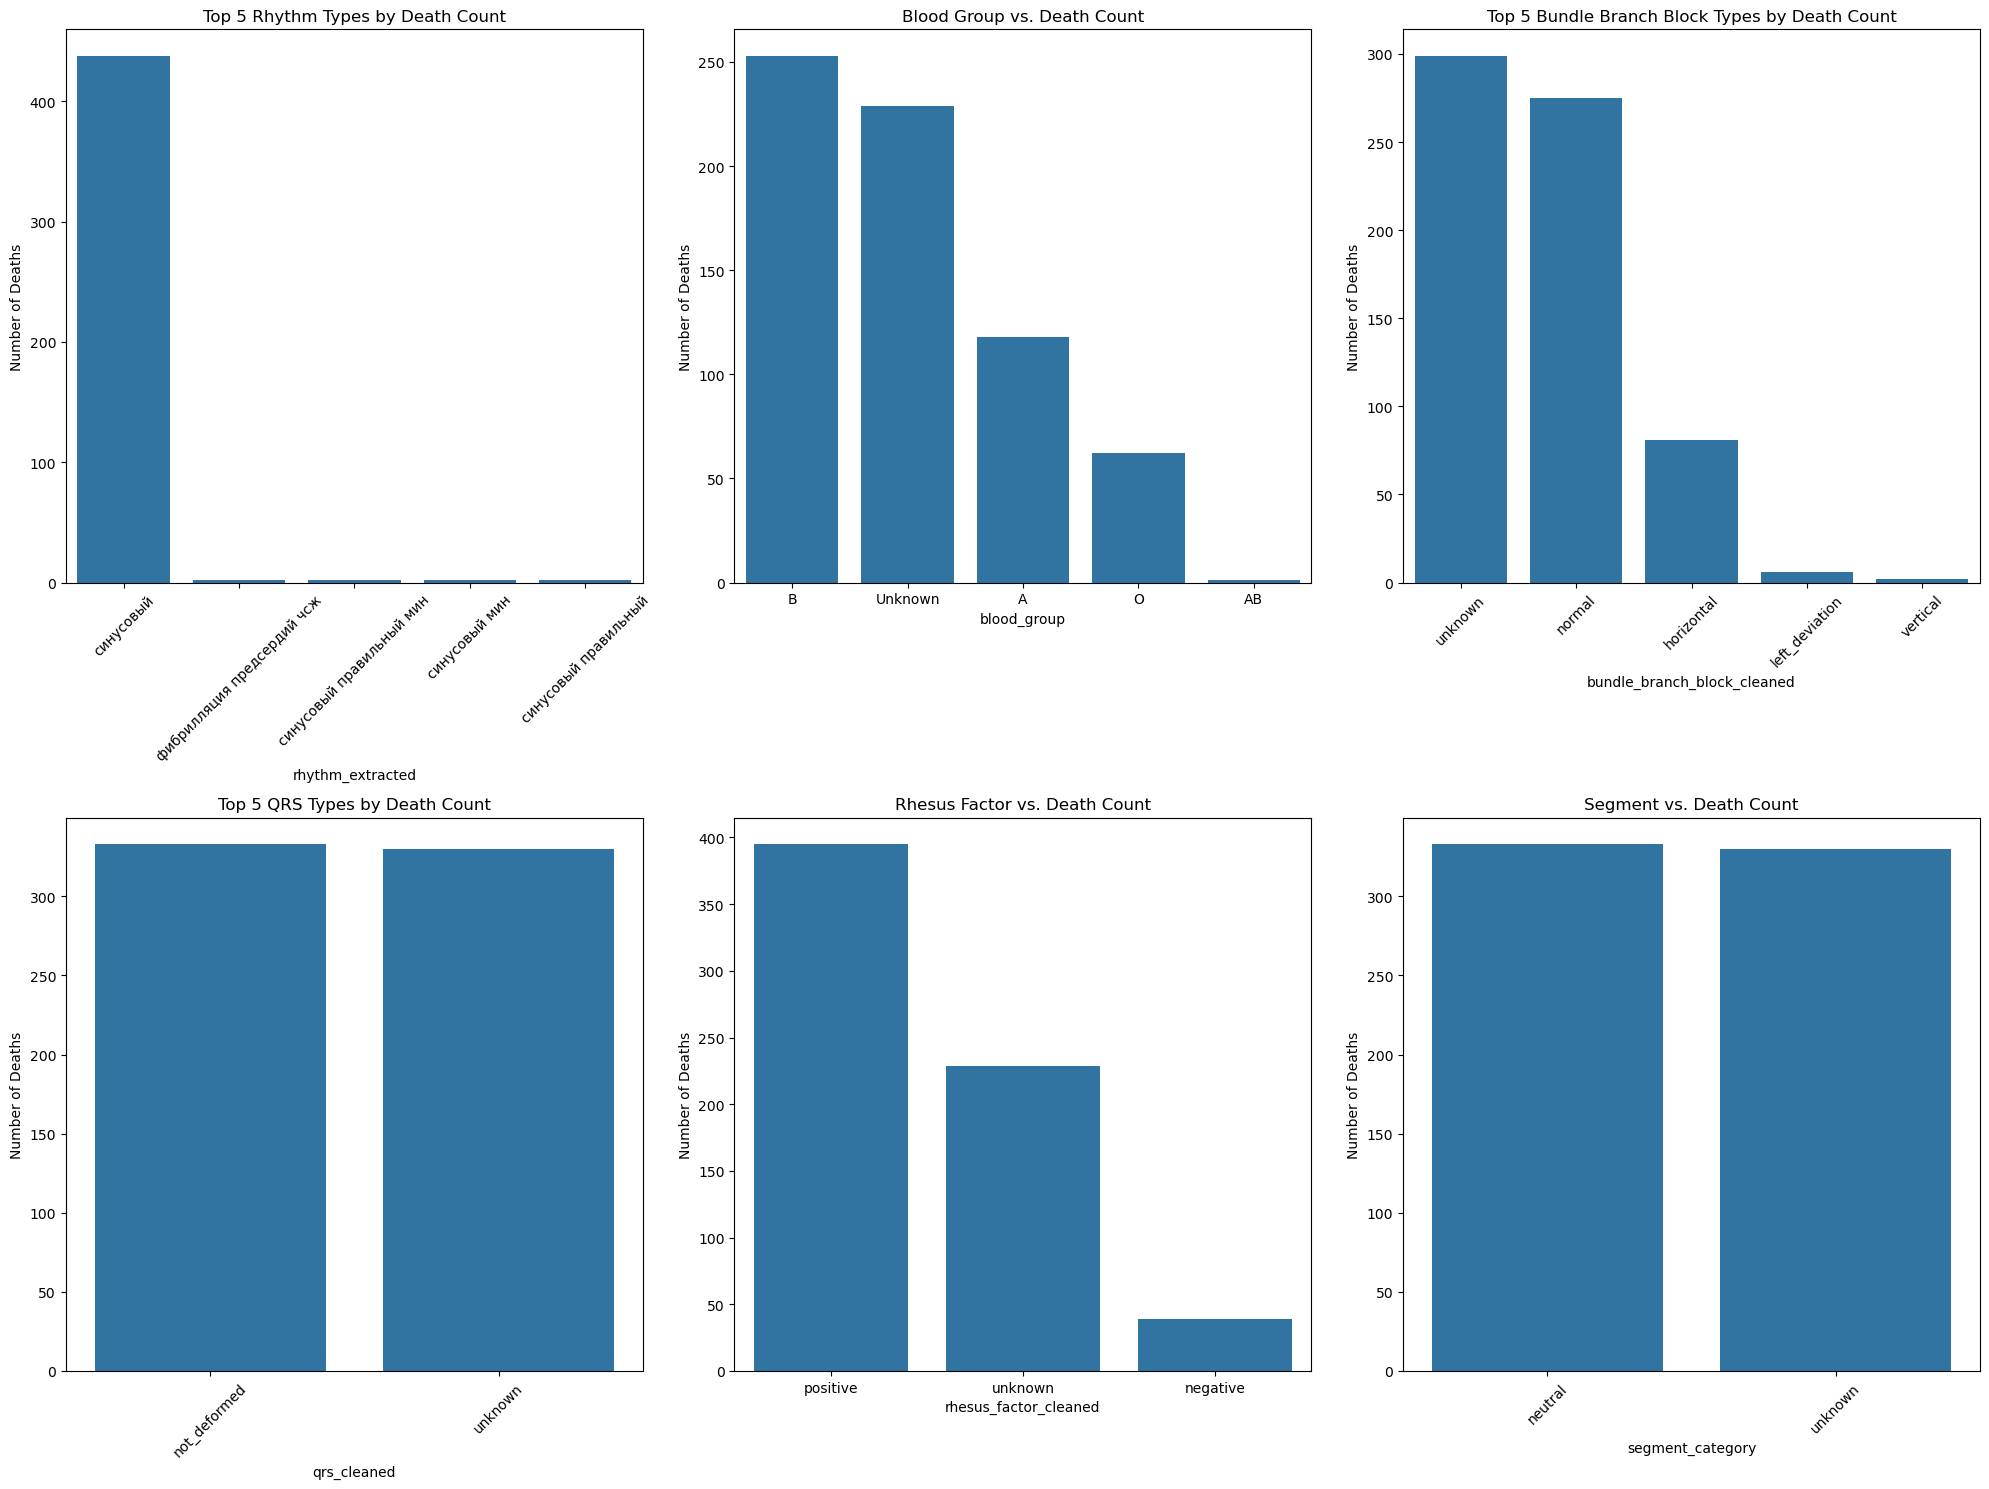

In [30]:
# Function to compute number of deaths for categorical variables
def compute_death_counts(column):
    return df[df["dead"] == 1][column].value_counts()

# Compute death counts for categorical variables using cleaned column names
rhythm_death_counts = compute_death_counts("rhythm_extracted").nlargest(5)
blood_group_death_counts = compute_death_counts("blood_group")
bundle_branch_death_counts = compute_death_counts("bundle_branch_block_cleaned").nlargest(5)
qrs_death_counts = compute_death_counts("qrs_cleaned").nlargest(5)
rhesus_death_counts = compute_death_counts("rhesus_factor_cleaned")
segment_death_counts = compute_death_counts("segment_category").nlargest(5)

# Create subplots for visualization (2 rows, 3 columns)
fig, axes = plt.subplots(2, 3, figsize=(20, 15))

# Plot Rhythm Death Counts
sns.barplot(x=rhythm_death_counts.index, y=rhythm_death_counts.values, ax=axes[0, 0])
axes[0, 0].set_title("Top 5 Rhythm Types by Death Count")
axes[0, 0].set_ylabel("Number of Deaths")
axes[0, 0].tick_params(axis='x', rotation=45)

# Plot Blood Group Death Counts
sns.barplot(x=blood_group_death_counts.index, y=blood_group_death_counts.values, ax=axes[0, 1])
axes[0, 1].set_title("Blood Group vs. Death Count")
axes[0, 1].set_ylabel("Number of Deaths")

# Plot Bundle Branch Block Death Counts
sns.barplot(x=bundle_branch_death_counts.index, y=bundle_branch_death_counts.values, ax=axes[0, 2])
axes[0, 2].set_title("Top 5 Bundle Branch Block Types by Death Count")
axes[0, 2].set_ylabel("Number of Deaths")
axes[0, 2].tick_params(axis='x', rotation=45)

# Plot QRS Cleaned Death Counts
sns.barplot(x=qrs_death_counts.index, y=qrs_death_counts.values, ax=axes[1, 0])
axes[1, 0].set_title("Top 5 QRS Types by Death Count")
axes[1, 0].set_ylabel("Number of Deaths")
axes[1, 0].tick_params(axis='x', rotation=45)

# Plot Rhesus Factor Death Counts
sns.barplot(x=rhesus_death_counts.index, y=rhesus_death_counts.values, ax=axes[1, 1])
axes[1, 1].set_title("Rhesus Factor vs. Death Count")
axes[1, 1].set_ylabel("Number of Deaths")

# Plot Segment Death Counts
sns.barplot(x=segment_death_counts.index, y=segment_death_counts.values, ax=axes[1, 2])
axes[1, 2].set_title("Segment vs. Death Count")
axes[1, 2].set_ylabel("Number of Deaths")
axes[1, 2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

### Insights from Death Counts by Feature

Top 5 Rhythm Types by Death Count
Sinus rhythm ("синусовый") is the most common, but this is likely due to it being the dominant category overall.
Some abnormal rhythms (atrial fibrillation, pacemaker-related rhythms) are present but with fewer cases.

Blood Group vs. Death Count
Blood group B has the highest number of deaths.
Group A and O follow, while AB has the lowest count.

Top 5 Bundle Branch Block Types by Death Count
"Normal" and "horizontal" conduction types have the highest death counts.
"Left deviation" and "vertical" bundle branch blocks appear in smaller numbers.

Top 5 QRS Types by Death Count
"Not deformed" QRS complexes appear most frequently among deceased patients.
A large number of QRS types are classified as "unknown", indicating possible missing or unclear data.

Rhesus Factor vs. Death Count
"Positive" Rhesus factor is the most common among deceased patients, which aligns with its general prevalence.
"Unknown" values are quite high, suggesting missing or unrecorded data.

Segment Type & Death Count
Most deaths fall under "изоэлектричен" (isoelectric segment).
Some categories have very small representation, indicating possible missing values.

#### Convert Categorical  Columns to Numerical Using LabelEncoder

In [31]:
# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Columns that should be Label Encoded (low-cardinality categories)
label_encode_columns = ["qrs_cleaned", "sex", "rhesus_factor_cleaned", "bundle_branch_block_cleaned", "blood_group","segment_category"]

# Apply Label Encoding
for col in label_encode_columns:
    df[col] = label_encoder.fit_transform(df[col].fillna("unknown"))  # Replace NaN with 'unknown'

# Convert high-cardinality categorical features to categorical type (for CatBoost, XGBoost)
df["rhythm_extracted"] = df["rhythm_extracted"].astype("category")

### Description

#### Lemmatization & Stopword Removal

In [32]:
# Function to preprocess description column
def clean_description(text):
    if isinstance(text, str):
        doc = nlp(text.lower())  # Convert to lowercase and process with spaCy

        # Keep only meaningful words (nouns, adjectives)
        cleaned_text = " ".join([token.lemma_ for token in doc if token.pos_ in ["NOUN", "ADJ"] and not token.is_stop])
        return cleaned_text
    return ""

# Apply cleaning function
df["description_cleaned"] = df["description"].apply(clean_description)

#### Named Entity Recognition (NER)

In [33]:
# Function to extract medical terms using Named Entity Recognition (NER)
def extract_medical_terms(text):
    if isinstance(text, str):
        doc = nlp(text.lower())

        # Extract entities related to medical conditions or ECG abnormalities
        entities = [ent.text for ent in doc.ents]
        return ", ".join(entities) if entities else "No entity found"
    return "No data"

# Apply NER extraction
df["description_entities"] = df["description"].apply(extract_medical_terms)

#### TF-IDF Vectorization

In [34]:
# Apply TF-IDF
vectorizer = TfidfVectorizer(max_features=50)  # Limit to top 50 features
tfidf_matrix = vectorizer.fit_transform(df["description_cleaned"].fillna(""))

# Convert to DataFrame
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())

# Merge TF-IDF features with main DataFrame
df_tfidf = pd.concat([df, tfidf_df], axis=1)

#### Topic Modeling (LDA)

In [35]:
# Apply LDA with 5 topics
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda_topics = lda.fit_transform(tfidf_matrix)

# Assign topic labels
df["description_topic"] = lda_topics.argmax(axis=1)

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


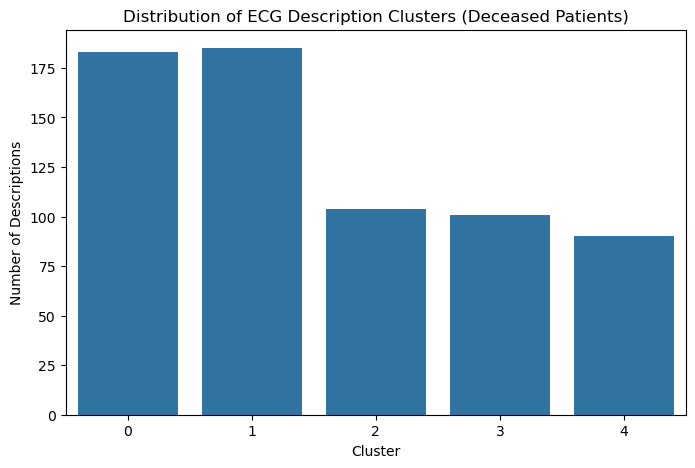

In [37]:
# Filter only deceased patients ('dead == 1')
df_dead_tfidf = df[df["dead"] == 1].reset_index(drop=True)
# Get TF-IDF values for deceased only
tfidf_matrix_dead = tfidf_df.loc[df_dead_tfidf.index]  

# Reduce Dimensions with PCA
pca = PCA(n_components=10)  # Reduce to 10 key features
tfidf_reduced_dead = pca.fit_transform(tfidf_matrix_dead)

# Apply Clustering
num_clusters = 5  # Set number of clusters
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
df_dead_tfidf["description_cluster"] = kmeans.fit_predict(tfidf_reduced_dead)

# Visualize the Cluster Distributions
plt.figure(figsize=(8, 5))
sns.countplot(x=df_dead_tfidf["description_cluster"])
plt.title("Distribution of ECG Description Clusters (Deceased Patients)")
plt.xlabel("Cluster")
plt.ylabel("Number of Descriptions")
plt.show()

In [38]:
for cluster in range(5):
    print(f"Cluster {cluster} Top Words:")
    print(df_dead_tfidf[df_dead_tfidf["description_cluster"] == cluster]["description"].str.cat(sep=" ").split()[:20])

Cluster 0 Top Words:
['Ритм', 'синусовый.', 'Нормальное', 'положение', 'ЭОС.', 'ЭКГ', 'в', 'пределах', 'нормы.', 'Ритм', 'синусовый.', 'Нормальное', 'положение', 'ЭОС.', 'ЭКГ', 'в', 'пределах', 'нормы.', 'Ритм', 'синусовый.']
Cluster 1 Top Words:
['Синусовая', 'тахикардия.', 'Нормальное', 'положение', 'ЭОС.', 'ЭКГ', 'в', 'пределах', 'нормы.', 'ЭКГ', 'в', 'пределах', 'нормы.', 'Ритм', 'синусовый.', 'ЭОС', 'типа', 'S1-QIII.', 'Рисунок', 'ЭКГ']
Cluster 2 Top Words:
['Ритм', 'синусовый.', 'ЭОС', 'типа', 'S1-QIII.', 'Рисунок', 'ЭКГ', 'в', 'пределах', 'нормы.', 'Ритм', 'синусовый.', 'Нормальное', 'положение', 'ЭОС.', 'Рисунок', 'ЭКГ', 'в', 'пределах', 'нормы.']
Cluster 3 Top Words:
['Ритм', 'синусовый.', 'Нормальное', 'положение', 'ЭОС.', 'Рисунок', 'ЭКГ', 'в', 'пределах', 'нормы.', 'ЭКГ', 'в', 'пределах', 'нормы.', 'Ритм', 'синусовый.', 'Нормальное', 'положение', 'ЭОС.', 'Рисунок']
Cluster 4 Top Words:
['Ритм', 'синусовый.', 'Нормальное', 'положение', 'ЭОС.', 'ЭКГ', 'в', 'пределах', 'нормы.

### Observations for Each Cluster

Cluster 0 (Most Common Terms)
1. Ритм синусовый → Sinus rhythm
2. Нормальное положение ЭОС → Normal electrical axis (EOS)
3. ЭКГ в пределах нормы → ECG within normal limits
Insight:
This cluster likely represents patients who had a "normal" ECG description before death.
These cases might have died from non-cardiac causes or from undetected abnormalities.

Cluster 1 (Sinus Tachycardia Cases)
"Синусовая тахикардия" → Sinus tachycardia
"ЭОС типа S1-QIII" → S1-QIII ECG pattern (possible right heart strain)

Insight:
These patients had sinus tachycardia, which could indicate shock, heart failure, or pulmonary embolism.
The "S1-QIII" pattern is often associated with pulmonary hypertension or right heart strain.

Cluster 2 (Similar to Cluster 0, but with S1-QIII Pattern)
1. Ритм синусовый → Sinus rhythm
2. ЭОС типа S1-QIII → S1-QIII pattern
3. Рисунок ЭКГ в пределах нормы → ECG "normal" pattern

Insight:
Similar to Cluster 0, but more emphasis on the S1-QIII pattern.
Might indicate undiagnosed pulmonary conditions.

Cluster 3 (Generic Normal ECG Cases)
1. Ритм синусовый → Sinus rhythm
2. Нормальное положение ЭОС → Normal EOS position
3. ЭКГ в пределах нормы → ECG within normal limits

Insight:
This is similar to Cluster 0 but may contain more generic normal ECGs.
These could be routine ECG reports for patients who later developed complications.

Cluster 4 (Almost Identical to Cluster 0)
1. Ритм синусовый → Sinus rhythm
2. Нормальное положение ЭОС → Normal EOS position
3. ЭКГ в пределах нормы → ECG within normal limits

Insight:
Almost identical to Cluster 0, likely another group of patients with no apparent ECG abnormalities.

### Key Takeaways
Most deceased patients had ECGs labeled as "normal" (Clusters 0, 3, and 4).

This suggests that cardiac events might not always be detected in standard ECG reports.
Some patients might have sudden cardiac arrests or ischemia that was not seen in routine ECGs.

Cluster 1 (Sinus Tachycardia) may indicate higher-risk patients.

Tachycardia before death could be a sign of worsening heart failure, shock, or arrhythmia.

Clusters with "S1-QIII" suggest possible pulmonary hypertension or embolism risks.

Right heart strain (S1-QIII) is a potential marker of undiagnosed respiratory or heart failure.

### Episodes

#### Lemmatization & Stopword Removal

In [46]:
# Function to preprocess episode column

df["episode_cleaned"] = df["episode"].apply(clean_description)

#### Named Entity Recognition (NER)

In [47]:
# Function to extract medical terms using Named Entity Recognition (NER)

df["episode_entities"] = df["episode"].apply(extract_medical_terms)

#### TF-IDF Vectorization

In [54]:
# Apply TF-IDF
tfidf_matrix_episode = vectorizer.fit_transform(df["episode_cleaned"].fillna(""))

# Convert to DataFrame
tfidf_df_episode = pd.DataFrame(tfidf_matrix_episode.toarray(), columns=vectorizer.get_feature_names_out())

# Merge TF-IDF features with main DataFrame
df_tfidf_new = pd.concat([df_tfidf, tfidf_df_episode], axis=1)

#### Topic Modeling (LDA)

In [55]:
# Apply LDA with 5 topics
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda_topics = lda.fit_transform(tfidf_matrix_episode)

# Assign topic labels
df["episode_topic"] = lda_topics.argmax(axis=1)

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


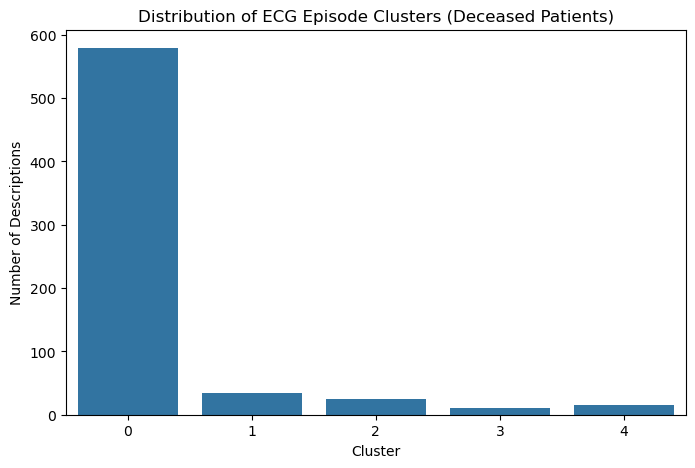

In [56]:
# Filter only deceased patients ('dead == 1')
df_dead_tfidf_new = df[df["dead"] == 1].reset_index(drop=True)

# Get TF-IDF values for deceased only
tfidf_matrix_dead_new = tfidf_df_episode.loc[df_dead_tfidf_new.index]  

# Reduce Dimensions with PCA
pca = PCA(n_components=10)  # Reduce to 10 key features
tfidf_reduced_dead_new = pca.fit_transform(tfidf_matrix_dead_new)

# Apply Clustering
num_clusters = 5  # Set number of clusters
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
df_dead_tfidf_new["episode_cluster"] = kmeans.fit_predict(tfidf_reduced_dead_new)

# Visualize the Cluster Distributions
plt.figure(figsize=(8, 5))
sns.countplot(x=df_dead_tfidf_new["episode_cluster"])
plt.title("Distribution of ECG Episode Clusters (Deceased Patients)")
plt.xlabel("Cluster")
plt.ylabel("Number of Descriptions")
plt.show()

In [57]:
for cluster in range(5):
    print(f"Cluster {cluster} Top Words:")
    print(df_dead_tfidf_new[df_dead_tfidf_new["episode_cluster"] == cluster]["episode"].str.cat(sep=" ").split()[:20])

Cluster 0 Top Words:
['Первичная', 'госпитализация', 'в', 'кардиологическое', 'отделение', 'с', 'палатой', 'реанимации', 'и', 'интенсивной', 'терапии', 'АО', '«ЦЭЛТ»', 'Первичная', 'госпитализация', 'в', 'кардиологическое', 'отделение', 'с', 'палатой']
Cluster 1 Top Words:
['Осмотр', 'в', 'палате', 'Осмотр', 'в', 'палате', 'осмотр', 'в', 'палате', '(4-е', 'сутки', 'ИМ,', '4-е', 'сутки', 'после', 'ЧКВ)', 'Осмотр', 'в', 'палате', 'Осмотр']
Cluster 2 Top Words:
['Осмотр', 'в', 'палате', 'Первичный', 'осмотр', 'врача-', 'рентгенэдоваскулярного', 'хирурга', 'Осмотр', 'в', 'палате', 'РАО.', 'Осмотр', 'дежурным', 'кардиологом', 'в', 'палате', 'АРО', 'Осмотр', 'дежурным']
Cluster 3 Top Words:
['Первичный', 'осмотр', 'врача-', 'рентгенэдоваскулярного', 'хирурга', 'Осмотр', 'дежурным', 'кардиологом', 'ОСМОТР', 'СОВМЕСТНО', 'С', 'РУКОВОДИТЕЛЕМ', 'СОСУДИСТОГО', 'ЦЕНТРА', '(1-е', 'сутки', 'ИМ,', '1-е', 'сутки', 'после']
Cluster 4 Top Words:
['Осмотр', 'в', 'палате', 'АРО', 'Первичная', 'госпитализа

### Insights from ECG Episode Clusters
The cluster distribution from the episode column shows that Cluster 0 is dominant, while the other clusters have significantly fewer descriptions. This suggests that a majority of deceased patients share a common episode description pattern.

### Breakdown of Each Cluster
Let's analyze the most frequent words in each cluster:

Cluster 0: Primary Hospitalization & Intensive Care Cases

Frequent terms: "Первичная госпитализация" (Primary hospitalization), "реанимация" (Reanimation), "интенсивная терапия" (Intensive therapy).
Interpretation:
Most patients in this cluster were admitted to intensive care or a specialized cardiology unit.
This cluster likely represents high-risk patients who required immediate intervention.
These patients may have had severe cardiac conditions like acute myocardial infarction (MI), heart failure, or shock.

Cluster 1: Routine In-Hospital Monitoring

Frequent terms: "Осмотр в палате" (Ward examination), "4-е сутки после ЧКВ" (4th day post-PCI).
Interpretation:
Patients in this cluster were being monitored after procedures like PCI (Percutaneous Coronary Intervention).
Suggests that many deceased patients had undergone heart procedures before death.
Could indicate post-procedure complications or undiagnosed worsening conditions.

Cluster 2: Initial Examination by Cardiologists & Surgeons

Frequent terms: "Первичный осмотр" (Initial examination), "рентгенэндоваскулярный хирург" (Interventional radiologist).
Interpretation:
These patients were evaluated early on in their hospitalization.
Many mentions of radiology and surgical consultations suggest that they were considered for interventional or surgical procedures.
May represent unstable patients needing rapid diagnostic workups.

Cluster 3: Critical Patients with Multi-Disciplinary Team Evaluations

Frequent terms: "ОСМОТР СОВМЕСТНО С РУКОВОДИТЕЛЕМ СОСУДИСТОГО ЦЕНТРА" (Evaluation with Vascular Center Head), "сутки после ЧКВ" (First day post-PCI).
Interpretation:
Patients here were likely under close medical supervision.
Joint evaluations by specialists suggest complex cases needing multiple expert opinions.
Could indicate critically ill patients who were deteriorating despite treatment.

Cluster 4: Late-Stage Monitoring & Reassessments

Frequent terms: "Осмотр в палате" (Ward examination), "АРО" (Acute Resuscitation Unit).
Interpretation:
These patients were under regular evaluation before deterioration.
Some overlap with Cluster 0, but with more emphasis on post-procedure monitoring.
These cases may include patients who had complications but were not considered high risk initially.


### Key Takeaways
Most deceased patients (Cluster 0) required intensive care and emergency interventions.

Clusters 1, 2, 3 show patients who were post-surgery or under specialist evaluations, indicating possible complications.

Cluster 4 may include cases where complications were initially undetected but later became severe.

### Training and Testing Data

#### Select Numeric columns and fillna with median

In [105]:
# Select Only Numerical Columns Before Filling Missing Values
df_selected_numeric = df_tfidf_new.select_dtypes(include=[np.number])

# Fill NaN values with the median of each column
df_selected_filled = df_selected_numeric.fillna(df_selected_numeric.median())

# Verify Missing Values Are Fixed
print("Missing values after filling:", df_selected_filled.isnull().sum().sum())

Missing values after filling: 0


In [106]:
scaler = StandardScaler()
df_standardized = pd.DataFrame(scaler.fit_transform(df_selected_filled), columns=df_selected_filled.columns)

In [107]:
# Ensure Both Clusters Exist in `df_standardized`
df_standardized = df_standardized.copy()

# Merge Clusters and Fill Missing Values
df_standardized = df_standardized.merge(
    df_dead_tfidf["description_cluster"], 
    left_index=True, 
    right_index=True, 
    how="left"
)

df_standardized = df_standardized.merge(
    df_dead_tfidf_new["episode_cluster"], 
    left_index=True, 
    right_index=True, 
    how="left"
)

# Fill NaNs with a Default Value (-1) Before Conversion
df_standardized["description_cluster"] = df_standardized["description_cluster"].fillna(-1).astype(int)
df_standardized["episode_cluster"] = df_standardized["episode_cluster"].fillna(-1).astype(int)

# Verify NaN Values Are Fixed
print("Missing values after filling:", df_standardized[["description_cluster", "episode_cluster"]].isnull().sum())

Missing values after filling: description_cluster    0
episode_cluster        0
dtype: int64


In [112]:
df_standardized.isna().sum()

sex                    0
p_wave_1               0
p_wave_2               0
p_wave_3               0
t_wave_1               0
                      ..
чкв                    0
чтка                   0
эндоваскулярного       0
description_cluster    0
episode_cluster        0
Length: 123, dtype: int64

In [116]:
X = df_standardized.drop(columns=["dead"])  # Features
y = df["dead"]

# 80% Training, 20% Testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

### Trainining and Evalation of the model

In [117]:
# Initialize Models
logistic_model = LogisticRegression(max_iter=1000, random_state=42)
random_forest = RandomForestClassifier(n_estimators=100, random_state=42)
xgboost_model = XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42)
catboost_model = CatBoostClassifier(verbose=0, random_state=42)

# Train Models
logistic_model.fit(X_train, y_train)
random_forest.fit(X_train, y_train)
xgboost_model.fit(X_train, y_train)
catboost_model.fit(X_train, y_train)

C:\Users\Nirmal Dev Aravind\AppData\Roaming\Python\Python312\site-packages\xgboost\core.py:158: UserWarning: [00:12:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [118]:
# Evaluate Models
models = {
    "Logistic Regression": logistic_model,
    "Random Forest": random_forest,
    "XGBoost": xgboost_model,
    "CatBoost": catboost_model
}

# Store Results
results = []

for model_name, model in models.items():
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]  # Probability scores for ROC-AUC
    
    auc_roc = roc_auc_score(y_test, y_prob)
    report = classification_report(y_test, y_pred, output_dict=True)
    
    results.append({
        "Model": model_name,
        "AUC-ROC": auc_roc,
        "Accuracy": report["accuracy"],
        "Precision": report["1"]["precision"],
        "Recall": report["1"]["recall"],
        "F1-Score": report["1"]["f1-score"]
    })

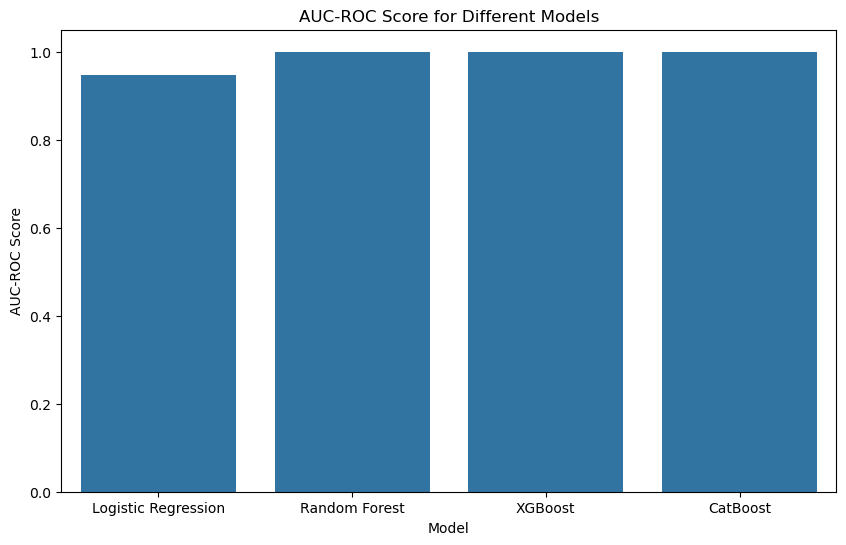

In [119]:
# Convert results to DataFrame
results_df = pd.DataFrame(results)

plt.figure(figsize=(10, 6))
sns.barplot(x="Model", y="AUC-ROC", data=results_df)
plt.title("AUC-ROC Score for Different Models")
plt.ylabel("AUC-ROC Score")
plt.show()

### SMOTE

In [120]:
# Check Class Distribution Before SMOTE
print("Before SMOTE:", Counter(y_train))

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Check Class Distribution After SMOTE
print("After SMOTE:", Counter(y_train_resampled))

Before SMOTE: Counter({0: 116711, 1: 530})
After SMOTE: Counter({0: 116711, 1: 116711})


### Applying Neural Network

In [122]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

#  Define Neural Network Model
model = keras.Sequential([
    layers.Dense(128, activation="relu", input_shape=(X_train_resampled.shape[1],)),
    layers.Dropout(0.3),  # Prevent overfitting
    layers.Dense(64, activation="relu"),
    layers.Dense(32, activation="relu"),
    layers.Dense(1, activation="sigmoid")  # Binary classification
])

#  Compile Model
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

#  Train Model
model.fit(X_train_resampled, y_train_resampled, epochs=50, batch_size=32, validation_split=0.2)

C:\Users\Nirmal Dev Aravind\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
5836/5836 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.9579 - loss: 0.1080 - val_accuracy: 0.9988 - val_loss: 0.0105
Epoch 2/50
5836/5836 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - accuracy: 0.9926 - loss: 0.0223 - val_accuracy: 0.9993 - val_loss: 0.0080
Epoch 3/50
5836/5836 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - accuracy: 0.9943 - loss: 0.0172 - val_accuracy: 0.9951 - val_loss: 0.0146
Epoch 4/50
5836/5836 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.9960 - loss: 0.0128 - val_accuracy: 0.9980 - val_loss: 0.0086
Epoch 5/50
5836/5836 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - accuracy: 0.9963 - loss: 0.0113 - val_accuracy: 0.9989 - val_loss: 0.0044
Epoch 6/50
5836/5836 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - accuracy: 0.9964 - loss: 0.0113 - val_accuracy: 1.0000 - val_loss: 0.0018
Epoch 7/50
5836/5836 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - accuracy: 0.9968 - loss: 0.0097 - val_accuracy: 0.9994 - val_loss: 0.0028
Epoch 8/50
5836/5836 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.9972 - loss: 0.0090 -

In [123]:
# Define CatBoost with Tuned Parameters
catboost_model_tuned = CatBoostClassifier(
    iterations=1000,
    depth=8,
    learning_rate=0.05,
    loss_function="Logloss",
    eval_metric="AUC",
    verbose=200,
    random_state=42
)

# Train with Best Hyperparameters
catboost_model_tuned.fit(X_train_resampled, y_train_resampled)

0:	total: 360ms	remaining: 5m 59s
200:	total: 16s	remaining: 1m 3s
400:	total: 31.1s	remaining: 46.5s
600:	total: 44.4s	remaining: 29.5s
800:	total: 57.4s	remaining: 14.3s
999:	total: 1m 10s	remaining: 0us


In [125]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)

print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

916/916 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9983 - loss: 0.0253
Test Accuracy: 0.9983
Test Loss: 0.0312


In [126]:
# Get predicted probabilities
y_pred_probs = model.predict(X_test)

# Convert probabilities to binary classification (0 or 1)
y_pred = (y_pred_probs > 0.5).astype(int)


916/916 ━━━━━━━━━━━━━━━━━━━━ 1s 690us/step


In [128]:
from sklearn.metrics import classification_report, roc_auc_score

# Compute AUC-ROC Score
auc_roc = roc_auc_score(y_test, y_pred_probs)

# Print Classification Report
print("Classification Report:\n", classification_report(y_test, y_pred))

print(f"AUC-ROC Score: {auc_roc:.4f}")

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     29178
           1       0.79      0.86      0.82       133

    accuracy                           1.00     29311
   macro avg       0.89      0.93      0.91     29311
weighted avg       1.00      1.00      1.00     29311

AUC-ROC Score: 0.9774
